# 프로젝트 :  Segmentation map으로 도로 이미지 만들기
## 🎯 루브릭 평가
1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.
2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.
3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

In [22]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. 데이터 준비하기

* [cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)

In [3]:
# !cd ~/aiffel/conditional_generation/data & wget https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip
# !cd ~/aiffel/conditional_generation/data && unzip cityscapes.zip

In [5]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes'
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')

In [17]:
print("number of train examples :", len(os.listdir(train_path)))
print("number of valid examples :", len(os.listdir(val_path)))

number of train examples : 1000
number of valid examples : 5


train 데이터를 시각화하여 확인해보자.

In [8]:
train_images_path = glob.glob(os.path.join(train_path,'*'))
train_images_path[:5]

['/aiffel/aiffel/conditional_generation/data/cityscapes/train/711.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/286.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/212.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/993.jpg',
 '/aiffel/aiffel/conditional_generation/data/cityscapes/train/991.jpg']

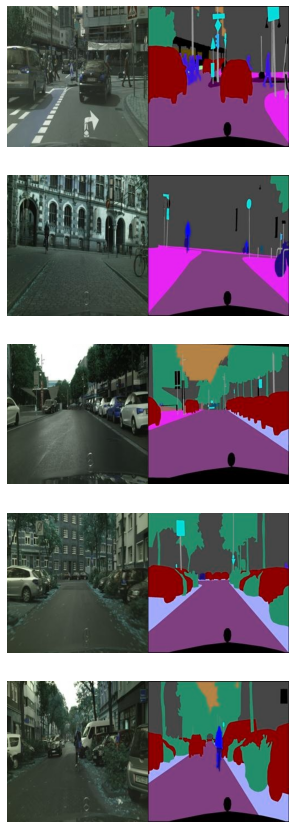

In [20]:
fig, axes =plt.subplots(nrows=5, figsize=(20,15))
for image_path, ax in zip(train_images_path, axes.flatten()):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    ax.imshow(image)
    ax.axis("off")

하나의 이미지에 실제 도로 이미지와 segmentation된 결과가 합쳐져 있다.

In [21]:
image = cv2.imread(train_images_path[0], cv2.IMREAD_COLOR)
print(f'image size:{image.shape}')

image size:(256, 512, 3)


이미지 사이즈가 (256, 512, 3) 이므로 (256, 256, 3)으로 분할한다.

In [23]:
# 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

# 정규화를 다시 되돌린다.
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

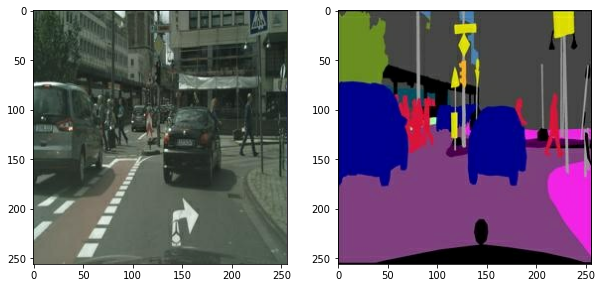

In [24]:
sketch, colored = load_img(train_images_path[0])

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## augmentation 적용

In [25]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

##### apply_augmentation
* 랜덤으로 가장자리에 padding을 준다.
* 랜덤으로 crop된다.
* 랜덤으로 가로로 뒤집는다.
* 랜덤으로 세로로 뒤집는다.

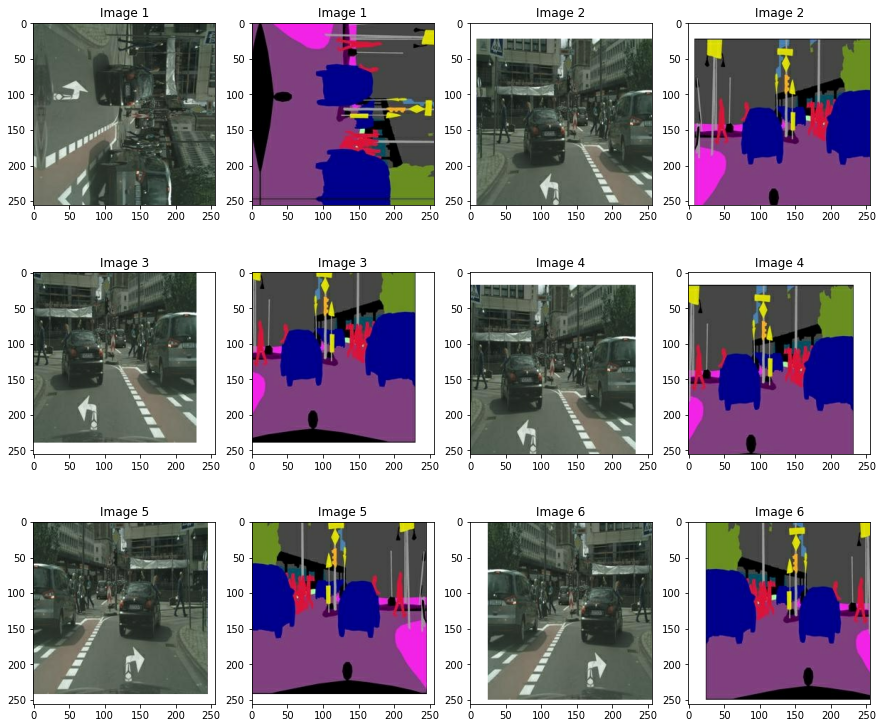

In [26]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

## 2. 입력 파이프라인

In [27]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [29]:
train_images = data.Dataset.list_files(train_path + "/*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

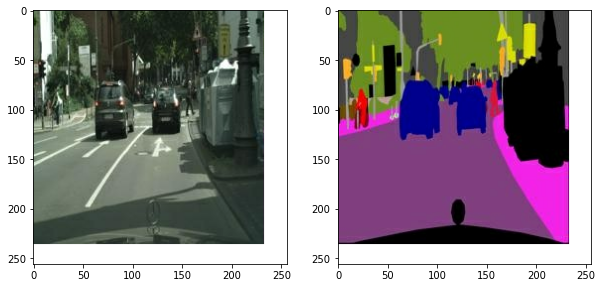

In [31]:
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 3. generator 구성
U-Net을 이용해 구성한다.

#### U-Net 구조
![image](https://user-images.githubusercontent.com/63278762/134177242-e98265df-b72d-4a1b-bf4c-35aa7f641571.png)

기본적인 블록

In [33]:
from tensorflow.keras import layers, Input, Model

In [34]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [35]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

U-net generator 구성

In [36]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [37]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 4. Discriminator 구성
Discriminator 기본 블록

In [38]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

입력에 따른 이미지의 크기가 맞는지 확인해본다.

In [39]:
inputs = Input((128,128,32))
# 1. 가로와 세로 각각 1씩 패딩되므로 (130,130,32) 크기를 가진다.
out = layers.ZeroPadding2D()(inputs)
# 2. OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 로 계산한다.
# stride=1, filtersize=4 (127,127,64)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
# 3. BatchNormalization과 LeakyReLU는 크기에 영향을 안줌.
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [40]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [41]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 5. 모델 학습

Generator 및 Discriminator의 loss와 optimizer 구성

In [42]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [43]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

가중치를 1회 업데이트 하는 과정을 구현

In [44]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 20

generator = UNetGenerator()
discriminator = Discriminator()

history={'g_loss':[], 'l1_loss':[], 'd_loss':[]}
for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['g_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['d_loss'].append(d_loss)
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9456                     
L1_loss:0.3185                     
Discriminator_loss:1.5748

EPOCH[1] - STEP[20]                     
Generator_loss:0.9018                     
L1_loss:0.2863                     
Discriminator_loss:1.0882

EPOCH[1] - STEP[30]                     
Generator_loss:1.0796                     
L1_loss:0.3206                     
Discriminator_loss:0.8579

EPOCH[1] - STEP[40]                     
Generator_loss:1.6204                     
L1_loss:0.2425                     
Discriminator_loss:0.6133

EPOCH[1] - STEP[50]                     
Generator_loss:1.2651                     
L1_loss:0.2586                     
Discriminator_loss:0.8157

EPOCH[1] - STEP[60]                     
Generator_loss:1.9135                     
L1_loss:0.2271                     
Discriminator_loss:0.4376

EPOCH[1] - STEP[70]                     
Generator_loss:2.0914                     
L1_loss:0.2326                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.6784                     
L1_loss:0.2129                     
Discriminator_loss:0.4652

EPOCH[3] - STEP[80]                     
Generator_loss:1.8289                     
L1_loss:0.1887                     
Discriminator_loss:0.4864

EPOCH[3] - STEP[90]                     
Generator_loss:1.9602                     
L1_loss:0.1839                     
Discriminator_loss:0.8820

EPOCH[3] - STEP[100]                     
Generator_loss:3.0073                     
L1_loss:0.1909                     
Discriminator_loss:0.4842

EPOCH[3] - STEP[110]                     
Generator_loss:3.2586                     
L1_loss:0.1764                     
Discriminator_loss:1.4130

EPOCH[3] - STEP[120]                     
Generator_loss:1.2695                     
L1_loss:0.2313                     
Discriminator_loss:0.6401

EPOCH[3] - STEP[130]                     
Generator_loss:1.5256                     
L1_loss:0.2245                

EPOCH[5] - STEP[130]                     
Generator_loss:2.0010                     
L1_loss:0.2024                     
Discriminator_loss:0.4073

EPOCH[5] - STEP[140]                     
Generator_loss:1.2328                     
L1_loss:0.1781                     
Discriminator_loss:0.7260

EPOCH[5] - STEP[150]                     
Generator_loss:0.9619                     
L1_loss:0.1839                     
Discriminator_loss:0.8800

EPOCH[5] - STEP[160]                     
Generator_loss:1.0817                     
L1_loss:0.1781                     
Discriminator_loss:0.7525

EPOCH[5] - STEP[170]                     
Generator_loss:2.0531                     
L1_loss:0.1656                     
Discriminator_loss:0.6310

EPOCH[5] - STEP[180]                     
Generator_loss:1.5044                     
L1_loss:0.2105                     
Discriminator_loss:0.4572

EPOCH[5] - STEP[190]                     
Generator_loss:1.5028                     
L1_loss:0.1801             

EPOCH[7] - STEP[190]                     
Generator_loss:2.3045                     
L1_loss:0.1952                     
Discriminator_loss:0.4783

EPOCH[7] - STEP[200]                     
Generator_loss:1.1218                     
L1_loss:0.1759                     
Discriminator_loss:0.6404

EPOCH[7] - STEP[210]                     
Generator_loss:1.7931                     
L1_loss:0.1939                     
Discriminator_loss:0.5375

EPOCH[7] - STEP[220]                     
Generator_loss:2.3335                     
L1_loss:0.1609                     
Discriminator_loss:1.3151

EPOCH[7] - STEP[230]                     
Generator_loss:1.2526                     
L1_loss:0.1669                     
Discriminator_loss:1.0760

EPOCH[7] - STEP[240]                     
Generator_loss:3.0365                     
L1_loss:0.2023                     
Discriminator_loss:1.1315

EPOCH[7] - STEP[250]                     
Generator_loss:2.7183                     
L1_loss:0.2240             

EPOCH[9] - STEP[250]                     
Generator_loss:2.9465                     
L1_loss:0.1823                     
Discriminator_loss:0.4932

EPOCH[10] - STEP[10]                     
Generator_loss:2.4606                     
L1_loss:0.1984                     
Discriminator_loss:0.2346

EPOCH[10] - STEP[20]                     
Generator_loss:2.2762                     
L1_loss:0.1608                     
Discriminator_loss:0.9190

EPOCH[10] - STEP[30]                     
Generator_loss:1.9039                     
L1_loss:0.1742                     
Discriminator_loss:0.9147

EPOCH[10] - STEP[40]                     
Generator_loss:1.4348                     
L1_loss:0.1479                     
Discriminator_loss:0.4641

EPOCH[10] - STEP[50]                     
Generator_loss:1.3625                     
L1_loss:0.2454                     
Discriminator_loss:0.4625

EPOCH[10] - STEP[60]                     
Generator_loss:1.5063                     
L1_loss:0.1876             

EPOCH[12] - STEP[60]                     
Generator_loss:1.0638                     
L1_loss:0.2069                     
Discriminator_loss:0.6600

EPOCH[12] - STEP[70]                     
Generator_loss:1.1123                     
L1_loss:0.1953                     
Discriminator_loss:0.6521

EPOCH[12] - STEP[80]                     
Generator_loss:2.0469                     
L1_loss:0.1937                     
Discriminator_loss:0.5405

EPOCH[12] - STEP[90]                     
Generator_loss:1.5459                     
L1_loss:0.1605                     
Discriminator_loss:0.5308

EPOCH[12] - STEP[100]                     
Generator_loss:1.0957                     
L1_loss:0.2020                     
Discriminator_loss:0.7658

EPOCH[12] - STEP[110]                     
Generator_loss:2.4236                     
L1_loss:0.1950                     
Discriminator_loss:0.2292

EPOCH[12] - STEP[120]                     
Generator_loss:2.3867                     
L1_loss:0.1602          

EPOCH[14] - STEP[120]                     
Generator_loss:1.4453                     
L1_loss:0.1717                     
Discriminator_loss:0.4970

EPOCH[14] - STEP[130]                     
Generator_loss:1.0126                     
L1_loss:0.1575                     
Discriminator_loss:0.7999

EPOCH[14] - STEP[140]                     
Generator_loss:0.6904                     
L1_loss:0.1533                     
Discriminator_loss:1.0164

EPOCH[14] - STEP[150]                     
Generator_loss:1.5899                     
L1_loss:0.1555                     
Discriminator_loss:0.3308

EPOCH[14] - STEP[160]                     
Generator_loss:2.6630                     
L1_loss:0.1781                     
Discriminator_loss:0.9040

EPOCH[14] - STEP[170]                     
Generator_loss:1.4477                     
L1_loss:0.1640                     
Discriminator_loss:0.5908

EPOCH[14] - STEP[180]                     
Generator_loss:2.2182                     
L1_loss:0.1763      

EPOCH[16] - STEP[180]                     
Generator_loss:1.8242                     
L1_loss:0.1514                     
Discriminator_loss:0.4257

EPOCH[16] - STEP[190]                     
Generator_loss:1.2661                     
L1_loss:0.1271                     
Discriminator_loss:0.5860

EPOCH[16] - STEP[200]                     
Generator_loss:3.4399                     
L1_loss:0.1300                     
Discriminator_loss:1.6115

EPOCH[16] - STEP[210]                     
Generator_loss:1.1833                     
L1_loss:0.1408                     
Discriminator_loss:1.2968

EPOCH[16] - STEP[220]                     
Generator_loss:2.9521                     
L1_loss:0.1502                     
Discriminator_loss:0.8572

EPOCH[16] - STEP[230]                     
Generator_loss:2.4041                     
L1_loss:0.1475                     
Discriminator_loss:0.4483

EPOCH[16] - STEP[240]                     
Generator_loss:2.0715                     
L1_loss:0.1536      

## 6. 모델 테스트

# 회고

# Reference
* https://velog.io/@guide333/U-Net-%EC%A0%95%EB%A6%AC